In [5]:
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
def load_segments_from_files(infant_file_path: str, adult_file_path: str, min_length: int = 125) -> list[pd.DataFrame]:
    adult_file = pd.read_csv(adult_file_path)
    meaningfull_columns = ['Frame', 'success', "AU06_r", "AU12_r"]
    adult_file = adult_file[meaningfull_columns]

    infant_file = pd.read_csv(infant_file_path)
    infant_file = infant_file[meaningfull_columns]

    merged_file = pd.merge(infant_file, adult_file, on='Frame', how = 'inner', suffixes=('_infant', '_adult') )
    continous_dfs = []
    output_columns = ['Frame', 'AU06_r_infant', 'AU12_r_infant', 'AU06_r_adult', 'AU12_r_adult']
    current_segment = pd.DataFrame(columns=output_columns)
    for row in merged_file.itertuples():
        if row.success_infant >= 0.75 and row.success_adult >= 0.75:
            #print(row)
            current_segment.loc[len(current_segment)] = row.Frame, row.AU06_r_infant, row.AU12_r_infant, row.AU06_r_adult, row.AU12_r_adult
        else:
            if len(current_segment) > min_length:
                continous_dfs.append(current_segment)
                current_segment = pd.DataFrame(columns=output_columns)
            else:
                current_segment = pd.DataFrame(columns=output_columns)
    if len(current_segment) > min_length:
        continous_dfs.append(current_segment)
    return continous_dfs

In [5]:
segments = load_segments_from_files('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_5_2/Kamera 1/infant.csv',
                                     '/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_5_2/Kamera 2/adult.csv')

<Axes: xlabel='Frame'>

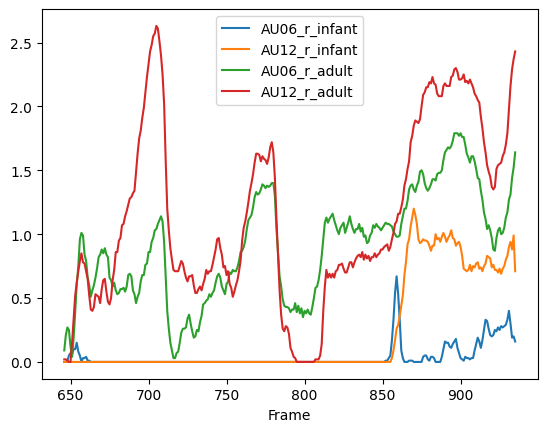

In [6]:
segments[0].plot(x = 'Frame', y=['AU06_r_infant', 'AU12_r_infant', 'AU06_r_adult', 'AU12_r_adult'])

In [6]:
import torch as t
import numpy as np

In [7]:
def segments_from_one_video_to_dataset(segments: list[pd.DataFrame], input_length: int,
                                   output_length: int, train_test_split: float = 0.8) -> tuple[t.Tensor, t.Tensor, t.Tensor, t.Tensor]:
    """
    It takes segments of one video and processes them into a dataset for training (with train and test split).

    Args:
        segments (list[pd.DataFrame]): Each DataFrame is one continuous segment with good tracking.
        input_length (int): Length of the input sequence.
        output_length (int): Length of the output sequence.
        train_test_split (float): Ratio of train/test split.

    Returns:
        tuple[t.Tensor, t.Tensor, t.Tensor, t.Tensor]: 
            - X_train (t.Tensor): Training input data.
            - y_train (t.Tensor): Training output data.
            - X_test (t.Tensor): Testing input data.
            - y_test (t.Tensor): Testing output data.
    """
    X = []
    Y = []
    for segment in segments:
        data = segment[['AU06_r_infant', 'AU12_r_infant', 'AU06_r_adult', 'AU12_r_adult']].to_numpy()
        num_samples = len(data) - input_length - output_length + 1
        for i in range(num_samples):
            X.append(data[i:i+input_length])
            Y.append(data[i+input_length:i+input_length+output_length])
    
    # Convert to NumPy arrays
    numpy_X = np.array(X, dtype=np.float32)
    numpy_Y = np.array(Y, dtype=np.float32)
    
    # Split into train and test sets
    split_idx = int(len(X) * train_test_split)
    train_X = t.from_numpy(numpy_X[:split_idx])
    train_Y = t.from_numpy(numpy_Y[:split_idx])
    test_X = t.from_numpy(numpy_X[split_idx:])
    test_Y = t.from_numpy(numpy_Y[split_idx:])


    return train_X, train_Y, test_X, test_Y

train_X_short, train_Y_short, test_X_short, test_Y_short = segments_from_one_video_to_dataset(segments, input_length=100, output_length=25)

NameError: name 'segments' is not defined

In [11]:
train_X_short, train_Y_short, test_X_short, test_Y_short = segments_from_one_video_to_dataset(segments, input_length=100, output_length=25)

In [3]:
from pathlib import Path

root = Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2")
subdirs = [p for p in root.iterdir() if p.is_dir()]
print(subdirs)

[PosixPath('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_24_1'), PosixPath('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_23_2'), PosixPath('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_45_4'), PosixPath('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_48_4'), PosixPath('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_6_1'), PosixPath('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_42_2'), PosixPath('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_22_4'), PosixPath('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_17_4'), PosixPath('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_20_2'), PosixPath('/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2/diti_30_2'), PosixPath('/net/tscratch/people/plgfimpro/korelacj

In [14]:
import torch as t
from utils import *

def load_multiple_files(month: int = 2) -> tuple[t.Tensor, t.Tensor, t.Tensor, t.Tensor]:
    root = Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2")
    subdirs = [p for p in root.iterdir() if p.is_dir()]
    train_X_list = []
    train_Y_list = []
    test_X_list = []
    test_Y_list = []
    for subdir in subdirs:
        if subdir.match(f"**/diti_*_{month}"):
            segments = load_segments_from_files(subdir/"Kamera 1/infant.csv",
                                               subdir/"Kamera 2/adult.csv")
            tX, tY, eX, eY = segments_from_one_video_to_dataset(segments, input_length=100, output_length=25)
            train_X_list.append(tX)
            train_Y_list.append(tY)
            test_X_list.append(eX)
            test_Y_list.append(eY)
    train_X = t.cat(train_X_list, dim=0)
    train_Y = t.cat(train_Y_list, dim=0)
    test_X = t.cat(test_X_list, dim=0)
    test_Y = t.cat(test_Y_list, dim=0)

        
    # Normalize based on training data
    mean = train_X.mean(dim=(0, 1), keepdim=True)
    std = train_X.std(dim=(0, 1), keepdim=True)

    print(mean, std)

    train_X = (train_X - mean) / (std + 1e-6)
    train_Y = (train_Y - mean) / (std + 1e-6)
    test_X = (test_X - mean) / (std + 1e-6)
    test_Y = (test_Y - mean) / (std + 1e-6)

    return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = load_multiple_files()

tensor([[[0.1213, 0.2268, 0.7177, 1.2874]]]) tensor([[[0.3125, 0.4000, 0.7446, 0.8783]]])


In [15]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        """
        Args:
            X (torch.Tensor): Input data of shape (num_samples, seq_len, input_dim).
            Y (torch.Tensor): Target data of shape (num_samples, seq_len, output_dim).
        """
        self.X = X
        self.Y = Y

    def __len__(self):
        # Return the number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # Return a single sample (X[idx], Y[idx])
        return self.X[idx], self.Y[idx]


In [16]:
train_dataset = TimeSeriesDataset(train_X, train_Y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TimeSeriesDataset(test_X, test_Y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
import torch
import torch.nn as nn
import math

In [19]:


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_dim=4,
        output_dim=4,
        d_model=128,
        nhead=8,
        num_encoder_layers=4,
        num_decoder_layers=4,
        dim_feedforward=512,
        dropout=0.1,
    ):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.output_proj = nn.Linear(d_model, output_dim)

        self.pos_encoder = PositionalEncoding(d_model)
        self.pos_decoder = PositionalEncoding(d_model)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, src, tgt):
        """
        src: (B, 100, 4)
        tgt: (B, 25, 4)  -> shifted right during training
        """
        src = self.input_proj(src)
        src = self.pos_encoder(src)

        tgt = self.input_proj(tgt)
        tgt = self.pos_decoder(tgt)

        out = self.transformer(src, tgt)
        out = self.output_proj(out)

        return out


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSeriesTransformer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_src, batch_tgt in train_loader:
        batch_src = batch_src.to(device)
        batch_tgt = batch_tgt.to(device)
        tgt_in = torch.zeros_like(batch_tgt)
        tgt_in[:, 1:, :] = batch_tgt[:, :-1, :]
        optimizer.zero_grad()
        output = model(batch_src, tgt_in)
        loss = criterion(output, batch_tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_src.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for val_src, val_tgt in test_loader:
            val_src = val_src.to(device)
            val_tgt = val_tgt.to(device)
            val_tgt_in = torch.zeros_like(val_tgt)
            val_tgt_in[:, 1:, :] = val_tgt[:, :-1, :]
            val_out = model(val_src, val_tgt_in)
            val_loss += criterion(val_out, val_tgt).item() * val_src.size(0)
    val_loss = val_loss / len(test_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} | train_loss={avg_loss:.4f} | val_loss={val_loss:.4f}")

KeyboardInterrupt: 

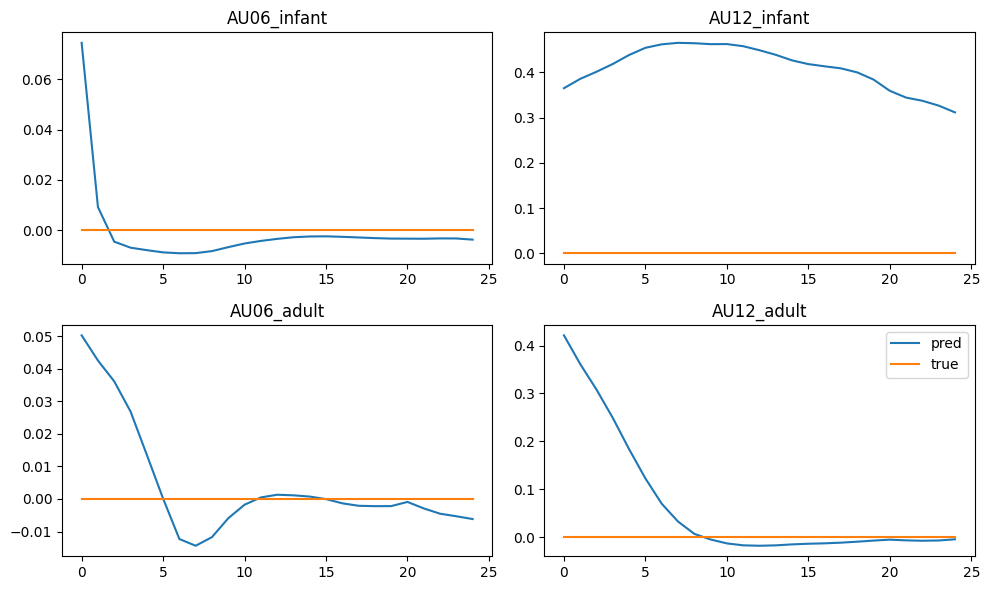

In [19]:
def autoregressive_predict(model, src, output_len):
    model.eval()
    preds = []
    decoder_input = torch.zeros((src.size(0), 1, src.size(2)), device=src.device)
    with torch.no_grad():
        for _ in range(output_len):
            out_step = model(src, decoder_input)
            next_token = out_step[:, -1:, :]
            preds.append(next_token)
            decoder_input = torch.cat([decoder_input, next_token], dim=1)
    return torch.cat(preds, dim=1)

test_src, test_tgt = next(iter(test_loader))
test_src = test_src.to(device)
test_tgt = test_tgt.to(device)
pred = autoregressive_predict(model, test_src, output_len=test_tgt.size(1))

sample_idx = 0
plt.figure(figsize=(10, 6))
labels = ['AU06_infant', 'AU12_infant', 'AU06_adult', 'AU12_adult']
for i, label in enumerate(labels):
    plt.subplot(2, 2, i + 1)
    plt.plot(pred[sample_idx, :, i].cpu().numpy(), label='pred')
    plt.plot(test_tgt[sample_idx, :, i].cpu().numpy(), label='true')
    plt.title(label)
    plt.tight_layout()
plt.legend()
plt.show()

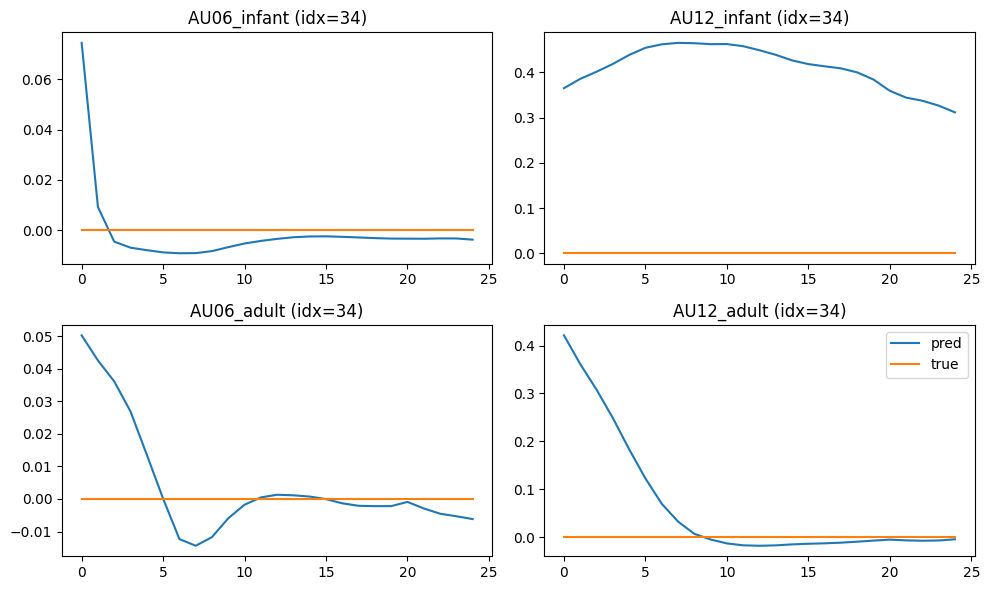

In [16]:
import torch
import matplotlib.pyplot as plt

# Evaluate on a random segment from the test set
rand_idx = torch.randint(0, len(test_dataset), (1,)).item()
src_single, tgt_single = test_dataset[rand_idx]
src_single = src_single.unsqueeze(0).to(device)
tgt_single = tgt_single.unsqueeze(0).to(device)
pred_single = autoregressive_predict(model, src_single, output_len=tgt_single.size(1))

plt.figure(figsize=(10, 6))
labels = ['AU06_infant', 'AU12_infant', 'AU06_adult', 'AU12_adult']
for i, label in enumerate(labels):
    plt.subplot(2, 2, i + 1)
    plt.plot(pred_single[0, :, i].cpu().numpy(), label='pred')
    plt.plot(tgt_single[0, :, i].cpu().numpy(), label='true')
    plt.title(f"{label} (idx={rand_idx})")
    plt.tight_layout()
plt.legend()
plt.show()

In [78]:
def generate_synthetic_dataset()->tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """
    Generates a synthetic dataset for testing the TimeSeriesDataset and DataLoader.
    Returns:
        tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]: 
            - DataLoader for synthetic training data.
            - DataLoader for synthetic testing data.
    """

    num_samples = 50000
    seq_len = 125
    input_dim = 4

    linspace = torch.linspace(0, 100, num_samples+125)
    synthetic_data = torch.stack([
        torch.sin(linspace) + 0.001 * torch.randn(num_samples + 125),
        torch.cos(linspace) + 0.001 * torch.randn(num_samples + 125),
        torch.sin(linspace + 1) + 0.001 * torch.randn(num_samples + 125),
        torch.cos(linspace + 1) + 0.001 * torch.randn(num_samples + 125),
    ], dim=1)


    X = []    
    Y = []
    for i in range(num_samples-1):
        X.append(synthetic_data[i:i+100])
        Y.append(synthetic_data[i+100:i+125])

    X = torch.stack(X)
    Y = torch.stack(Y)
    split_idx = int(num_samples * 0.8)
    train_X = X[:split_idx]
    train_Y = Y[:split_idx]
    test_X = X[split_idx:]
    test_Y = Y[split_idx:]
    train_dataset = TimeSeriesDataset(train_X, train_Y)
    test_dataset = TimeSeriesDataset(test_X, test_Y)

    return DataLoader(train_dataset, batch_size=32, shuffle=True), DataLoader(test_dataset, batch_size=32, shuffle=False), train_dataset, test_dataset
train_loader, test_loader, train_dataset, test_dataset = generate_synthetic_dataset()

In [79]:
import torch
import torch.nn as nn
import numpy as np
from utils import *
from models.maskedTimeSeriesTransformerWithHistory import MaskedTimeSeriesTransformerWithHistory as MaskedTimeSeriesTransformer

lr = 1e-3 # Increased slightly as scheduler will handle reduction
epochs = 3 # Increased max epochs since early stopping will catch it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming Model and Loaders are defined elsewhere
model = MaskedTimeSeriesTransformer(d_model=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Initialize Scheduler
# Factor 0.5 means LR becomes LR * 0.5
# Patience 3 means wait 3 epochs of no improvement before reducing LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# Initialize Early Stopping
early_stopping = EarlyStopping(patience=7, path='best_model.pt')

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    total_loss = 0.0
    
    for batch_src, batch_tgt in train_loader:
        batch_src = batch_src.to(device)
        batch_tgt = batch_tgt.to(device)

        # Prepare inputs
        child_src = batch_src[..., :2]
        mom_src = batch_src[..., 2:]
        
        tgt_in = torch.zeros_like(batch_tgt)
        tgt_in[:, 1:, :] = batch_tgt[:, :-1, :]
        child_tgt_in = tgt_in[..., :2]
        mom_tgt_in = tgt_in[..., 2:]

        mask_mom, mask_child = sample_mask_flags()

        optimizer.zero_grad()
        
        pred = model(
            child_src, mom_src, 
            child_tgt_in, mom_tgt_in, 
            mask_child=mask_child, mask_mom=mask_mom
        )
        src_len = batch_src.size(1)
        batch_ground = torch.cat([batch_src[:, src_len // 2:, :], batch_tgt], dim=1)
        #print(batch_ground.shape, pred.shape, batch_src.shape, batch_tgt.shape)
        loss = masked_mse_loss(pred, batch_ground, mask_child=mask_child, mask_mom=mask_mom)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_src.size(0)
    
    avg_train_loss = total_loss / len(train_loader.dataset)

    # --- Validation Phase ---
    model.eval()
    val_loss_accum = 0.0
    with torch.no_grad():
        for val_src, val_tgt in test_loader:
            val_src = val_src.to(device)
            val_tgt = val_tgt.to(device)

            val_child_src = val_src[..., :2]
            val_mom_src = val_src[..., 2:]
            
            val_tgt_in = torch.zeros_like(val_tgt)
            val_tgt_in[:, 1:, :] = val_tgt[:, :-1, :]
            val_child_tgt_in = val_tgt_in[..., :2]
            val_mom_tgt_in = val_tgt_in[..., 2:]

            val_pred = model(
                val_child_src, val_mom_src,
                val_child_tgt_in, val_mom_tgt_in,
                mask_child=False, mask_mom=False,
            )
            val_ground = torch.cat([val_src[:, val_src.size(1) // 2:, :], val_tgt], dim=1)
            # Usually we validate on the full unmasked loss
            val_loss_accum += masked_mse_loss(
                val_pred, val_ground, mask_child=False, mask_mom=False
            ).item() * val_src.size(0)
            
    avg_val_loss = val_loss_accum / len(test_loader.dataset)

    # --- Logging ---
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} | LR: {current_lr:.2e} | Train Loss: {avg_train_loss:.8f} | Val Loss: {avg_val_loss:.8f}")

    # --- Scheduler & Early Stopping Steps ---
    
    # 1. Step Scheduler (reduces LR if validation loss plateaus)
    scheduler.step(avg_val_loss)

    # 2. Check Early Stopping
    early_stopping(avg_val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Loading best model weights...")
        model.load_state_dict(torch.load('best_model.pt'))
        break

Epoch 1/3 | LR: 1.00e-03 | Train Loss: 0.08145116 | Val Loss: 0.02533423
Epoch 2/3 | LR: 1.00e-03 | Train Loss: 0.02807832 | Val Loss: 0.01530972
Epoch 3/3 | LR: 1.00e-03 | Train Loss: 0.01931122 | Val Loss: 0.00969561


In [94]:
!python train_with_history.py 

Epoch 1/10 | LR: 1.00e-03 | Train Loss: 0.02200124 | Val Loss: 0.00334344
Saved model to masked_model.pt
Epoch 2/10 | LR: 1.00e-03 | Train Loss: 0.00599137 | Val Loss: 0.00221599
Saved model to masked_model.pt
^C
Traceback (most recent call last):
  File "/net/tscratch/people/plgfimpro/korelacje/train_with_history.py", line 207, in <module>
    main()
  File "/net/tscratch/people/plgfimpro/korelacje/train_with_history.py", line 193, in main
    train_masked_model(
  File "/net/tscratch/people/plgfimpro/korelacje/train_with_history.py", line 122, in train_masked_model
    loss.backward()
  File "/net/tscratch/people/plgfimpro/miniconda3/envs/korelacje/lib/python3.11/site-packages/torch/_tensor.py", line 648, in backward
    torch.autograd.backward(
  File "/net/tscratch/people/plgfimpro/miniconda3/envs/korelacje/lib/python3.11/site-packages/torch/autograd/__init__.py", line 353, in backward
    _engine_run_backward(
  File "/net/tscratch/people/plgfimpro/miniconda3/envs/korelacje/lib/py

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import *
train_X, train_Y, test_X, test_Y = load_multiple_files(2, Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2"), 100, 50)
train_dataset =  TimeSeriesDataset(train_X, train_Y)
test_dataset = TimeSeriesDataset(test_X, test_Y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([1, 50, 4]) torch.Size([1, 50, 4])
torch.Size([1, 50, 4]) torch.Size([1, 50, 4])
torch.Size([1, 50, 4]) torch.Size([1, 50, 4])
torch.Size([1, 50, 4]) torch.Size([1, 50, 4])


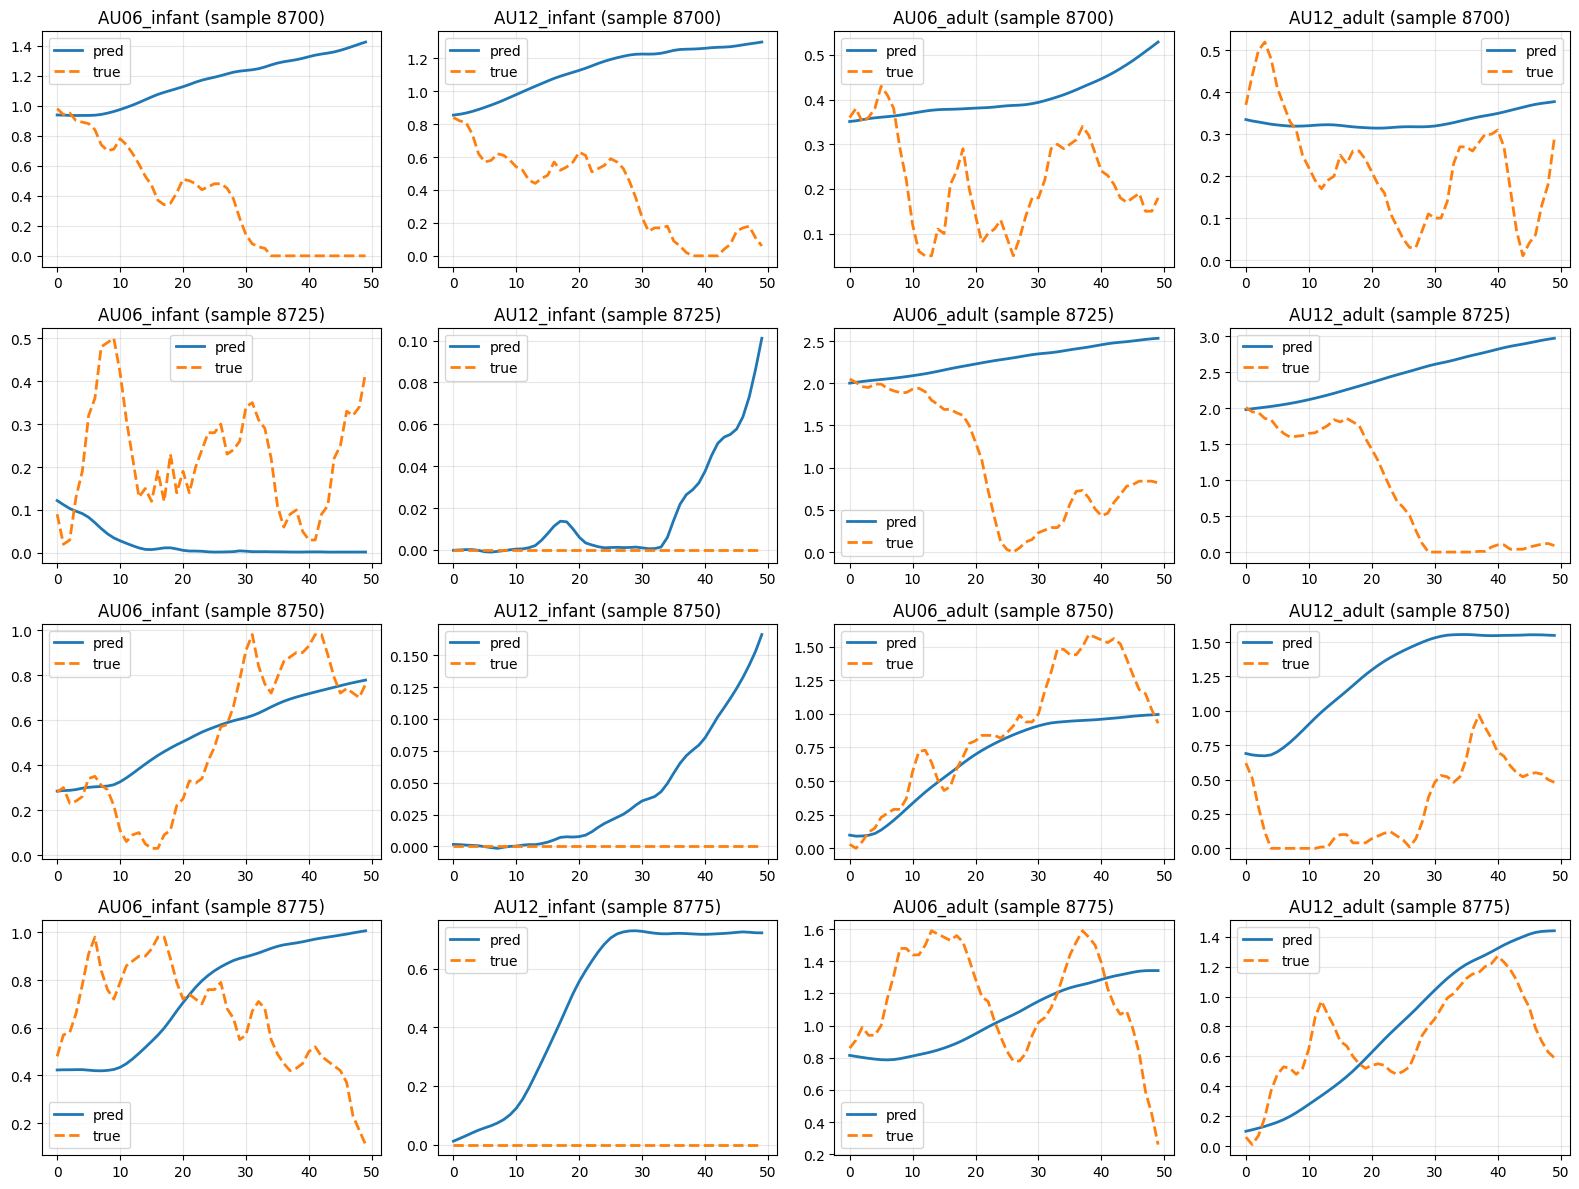

In [4]:
# Plot multiple test case predictions
from matplotlib import pyplot as plt
from models.maskedTimeSeriesTransformerWithHistory import MaskedTimeSeriesTransformerWithHistory as MaskedTimeSeriesTransformer
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MaskedTimeSeriesTransformer(d_model=32).to(device)
model.load_state_dict(torch.load('/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m1_in100_out50_lr1e-3-0.pt')['model_state_dict'])
num_examples = 4
start = 8700
fig, axes = plt.subplots(num_examples, 4, figsize=(16, 3 * num_examples))
labels = ['AU06_infant', 'AU12_infant', 'AU06_adult', 'AU12_adult']
test_idxs = [start, start+25, start+50, start+75]
model.eval()
with torch.no_grad():
    for example_idx in range(num_examples):
        rand_idx = test_idxs[example_idx]
        src_single, tgt_single = test_dataset[rand_idx]
        src_single = src_single.unsqueeze(0).to(device)
        tgt_single = tgt_single.unsqueeze(0).to(device)
        
        child_src = src_single[..., :2]
        mom_src = src_single[..., 2:]
        # Use autoregressive generation instead of passing zeros
        pred_single = model.forward_autoregressive(child_src, mom_src, 
                                    mask_child=False, mask_mom=False, tgt_len=tgt_single.size(1))
        print(pred_single.shape, tgt_single.shape)
        for feat_idx, label in enumerate(labels):
            ax = axes[example_idx, feat_idx]
            ax.plot(pred_single[0, :, feat_idx].cpu().numpy(), label='pred', linewidth=2)
            ax.plot(tgt_single[0, :, feat_idx].cpu().numpy(), label='true', linewidth=2, linestyle='--')
            ax.set_title(f"{label} (sample {rand_idx})")
            ax.legend()
            ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def plot_long_segment(start: int = 8500, timestep = 24, mask_mom = False, mask_child = False):
    num_examples = 1000
    true = []
    pred = []
    for example_idx in range(num_examples):
        rand_idx = start + example_idx
        src_single, tgt_single = test_dataset[rand_idx]
        src_single = src_single.unsqueeze(0).to(device)
        tgt_single = tgt_single.unsqueeze(0).to(device)
        
        child_src = src_single[..., :2]
        mom_src = src_single[..., 2:]
        # Use autoregressive generation instead of passing zeros
        pred_single = model.forward_autoregressive(child_src, mom_src, 
                                    mask_child=mask_child, mask_mom=mask_mom, tgt_len=tgt_single.size(1))
        #print(tgt_single.shape)
        #print(pred_single.shape)
        true.append(tgt_single[0,timestep].cpu().numpy())
        pred.append(pred_single[0, timestep].cpu().detach().numpy())
    print("MSE:", np.mean((np.array(true) - np.array(pred))**2, axis=0))
    fig, axes = plt.subplots(4, figsize=(16, 16))
    labels = ['AU06_infant', 'AU12_infant', 'AU06_adult', 'AU12_adult']
    for feat_idx, label in enumerate(labels):
        ax = axes[feat_idx]
        true_feat = [t[feat_idx] for t in true]
        pred_feat = [p[feat_idx] for p in pred]
        ax.plot(pred_feat, label='pred', linewidth=2)
        ax.plot(true_feat, label='true', linewidth=2, linestyle='--')
        ax.set_title(f"{label} over long segment, mse = {np.mean((np.array(true_feat) - np.array(pred_feat))**2):.6f}" + " with masked mom" if mask_mom else "" + " and masked child" if mask_child else "")
        ax.legend()
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [6]:
def calculate_MSE(model,start: int = 8500, timestep = 24, mask_mom = False, mask_child = False):
    num_examples = 500
    true = []
    pred = []
    for example_idx in range(num_examples):
        rand_idx = start + example_idx
        src_single, tgt_single = test_dataset[rand_idx]
        src_single = src_single.unsqueeze(0).to(device)
        tgt_single = tgt_single.unsqueeze(0).to(device)
        
        child_src = src_single[..., :2]
        mom_src = src_single[..., 2:]
        # Use autoregressive generation instead of passing zeros
        pred_single = model.forward_autoregressive(child_src, mom_src, 
                                    mask_child=mask_child, mask_mom=mask_mom, tgt_len=tgt_single.size(1))
        #print(tgt_single.shape)
        #print(pred_single.shape)
        true.append(tgt_single[0,timestep].cpu().numpy())
        pred.append(pred_single[0, timestep].cpu().detach().numpy())
    return np.mean((np.array(true) - np.array(pred))**2, axis=0)
    


MSE: [0.03778986 0.03516066 0.1325457  0.15229954]


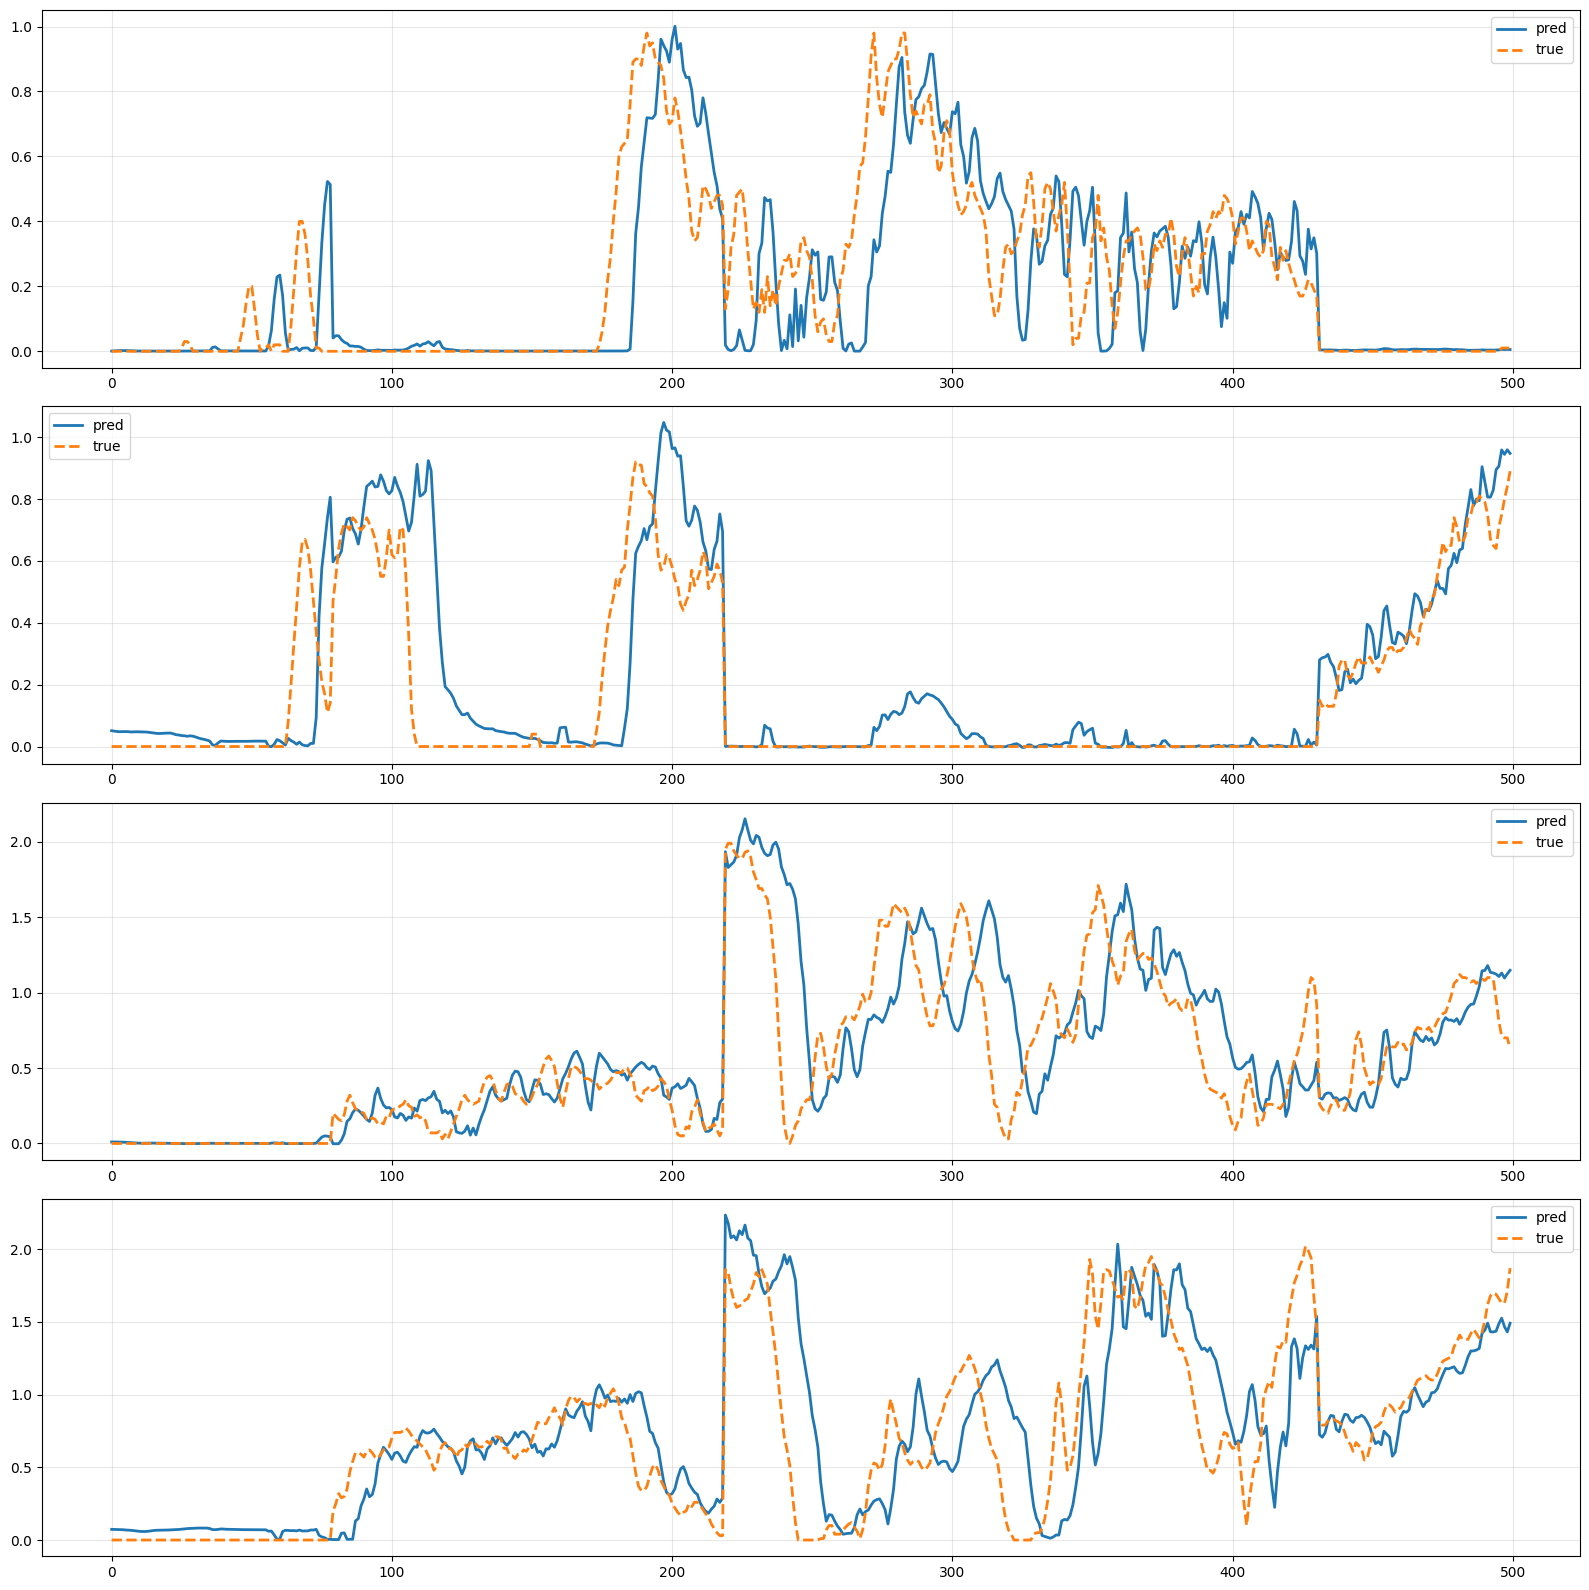

In [8]:
    

plot_long_segment(timestep=9, mask_mom=False, mask_child=False)

In [9]:
def calculate_MSE(model,start: int = 8500, timestep = 24, mask_mom = False, mask_child = False):
    num_examples = 500
    true = []
    pred = []
    for example_idx in range(num_examples):
        rand_idx = start + example_idx
        src_single, tgt_single = test_dataset[rand_idx]
        src_single = src_single.unsqueeze(0).to(device)
        tgt_single = tgt_single.unsqueeze(0).to(device)
        
        child_src = src_single[..., :2]
        mom_src = src_single[..., 2:]
        # Use autoregressive generation instead of passing zeros
        pred_single = model.forward_autoregressive(child_src, mom_src, 
                                    mask_child=mask_child, mask_mom=mask_mom, tgt_len=tgt_single.size(1))
        #print(tgt_single.shape)
        #print(pred_single.shape)
        true.append(tgt_single[0,timestep].cpu().numpy())
        pred.append(pred_single[0, timestep].cpu().detach().numpy())
    return np.mean((np.array(true) - np.array(pred))**2, axis=0)
    


In [ ]:
from pathlib import Path
import pandas as pd
import torch
from models.maskedTimeSeriesTransformerWithHistory import MaskedTimeSeriesTransformerWithHistory as MaskedTimeSeriesTransformer
import numpy as np
result_df = pd.DataFrame(columns=['model_name', 'mse_no_mask_mom_AU06_infant', 'mse_no_mask_mom_AU12_infant',
                             'mse_no_mask_mom_AU06_adult', 'mse_no_mask_mom_AU12_adult',
                             'mse_masked_mom_AU06_infant', 'mse_masked_mom_AU12_infant',
                             'mse_masked_mom_AU06_adult', 'mse_masked_mom_AU12_adult',
                             'mse_masked_child_AU06_infant', 'mse_masked_child_AU12_infant',
                             'mse_masked_child_AU06_adult', 'mse_masked_child_AU12_adult',
                            ])
for modelpath in list(Path('/net/tscratch/people/plgfimpro/korelacje/model_with_history/').glob('*-lr1e-3-?.pt')):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MaskedTimeSeriesTransformer(d_model=32).to(device)
    model.load_state_dict(torch.load(modelpath)['model_state_dict'])
    not_masked = calculate_MSE(model, timestep=9)
    masked_mom = calculate_MSE(model, timestep=9, mask_mom=True)
    masked_child = calculate_MSE(model, timestep=9, mask_child=True)
    result_df.loc[len(result_df)] = np.concatenate(([modelpath.name], not_masked, masked_mom, masked_child))
    print(modelpath)

/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m1_in100_out50_lr1e-3-2.pt
/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m2_in100_out50_lr1e-3-1.pt
/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m4_in100_out10_lr1e-3.pt
/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m4_in200_out10_lr1e-5.pt
/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m4_in200_out25_lr1e-4.pt
/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m4_in100_out50_lr1e-4.pt
/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m4_in100_out50_lr1e-5.pt
/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m4_in200_out50_lr1e-5.pt
/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m2_in100_out50_lr1e-3-0.pt
/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m4_in200_out10_lr1e-4.pt
/net/tscratch/people/plgfimpro/korelacje/model_with_history/masked_m2_in10

In [ ]:
result_df.to_csv('transformer_with_history_results_months.csv', index=False)


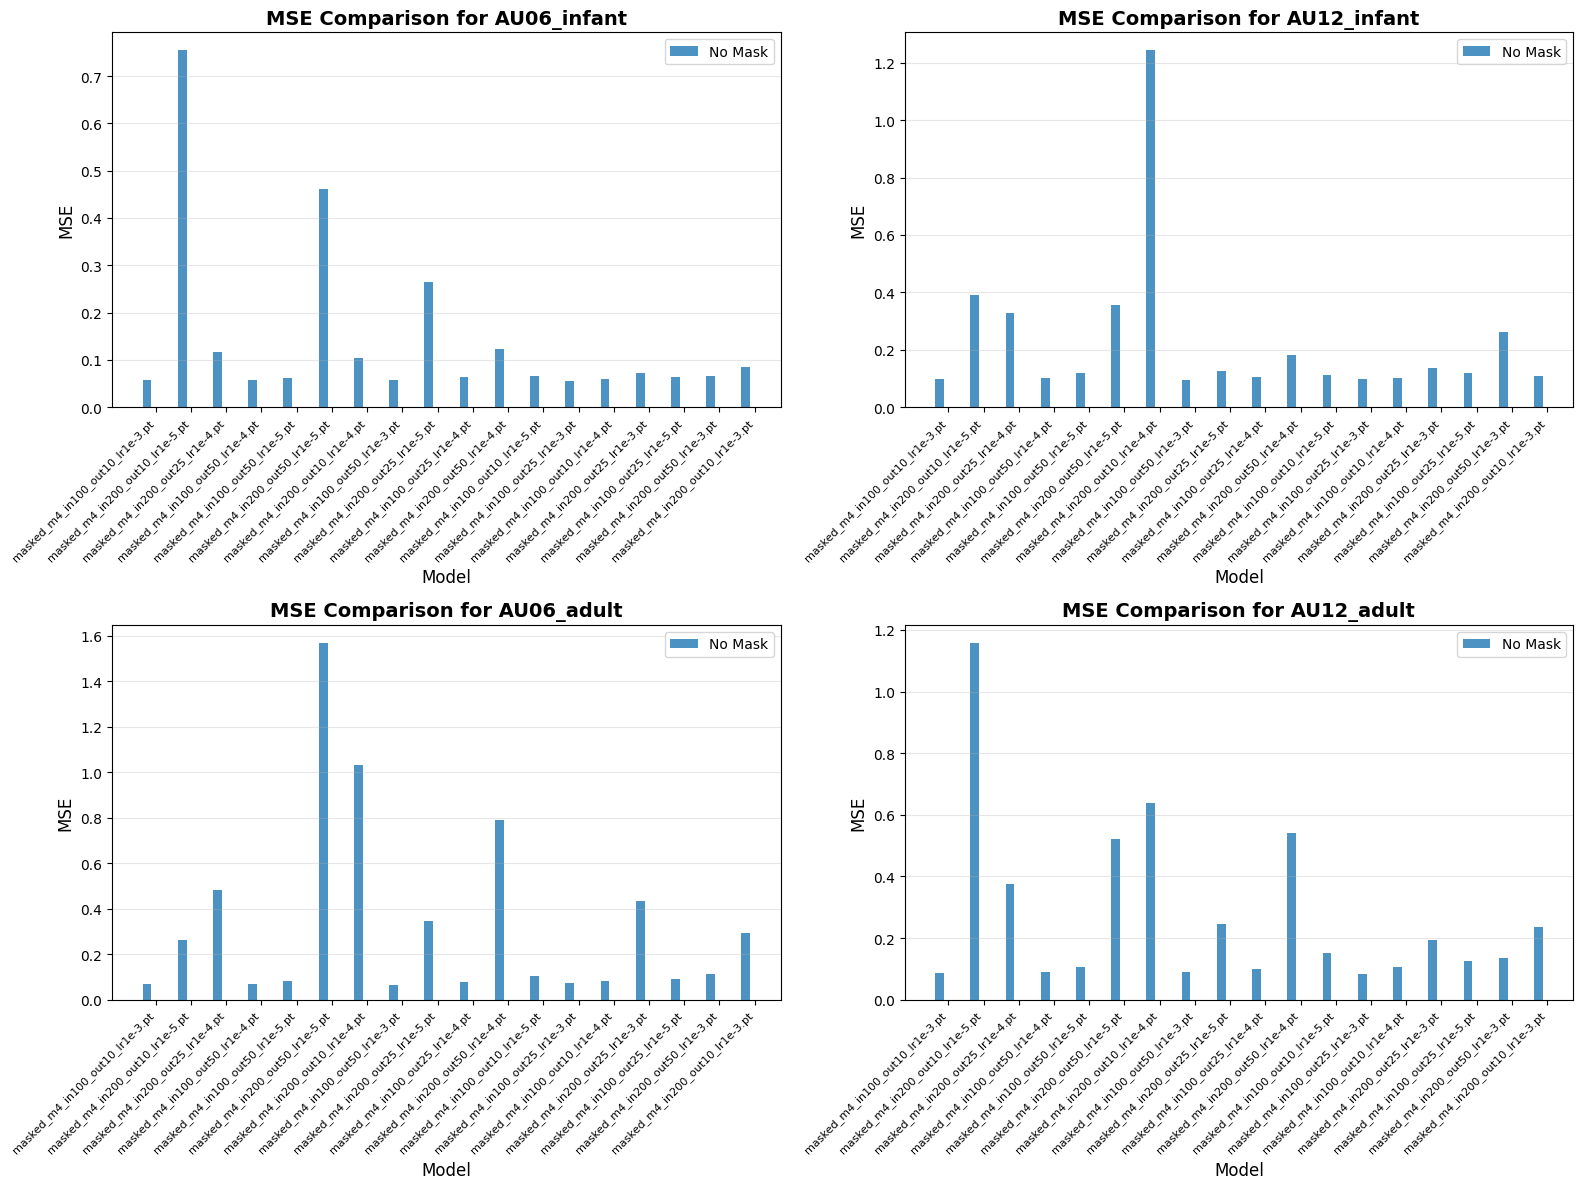


=== Summary Statistics ===

AU06_infant:
  No Mask:      mean=0.143979, std=0.182943
  Masked Mom:   mean=0.172409, std=0.287675
  Masked Child: mean=0.129146, std=0.143814

AU12_infant:
  No Mask:      mean=0.226698, std=0.272069
  Masked Mom:   mean=0.229065, std=0.247183
  Masked Child: mean=0.203615, std=0.209902

AU06_adult:
  No Mask:      mean=0.335183, std=0.413011
  Masked Mom:   mean=0.350993, std=0.438711
  Masked Child: mean=0.382652, std=0.442097

AU12_adult:
  No Mask:      mean=0.277066, std=0.281899
  Masked Mom:   mean=0.284055, std=0.451512
  Masked Child: mean=0.289633, std=0.295872


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create visualization of MSE results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
features = ['AU06_infant', 'AU12_infant', 'AU06_adult', 'AU12_adult']

for idx, feature in enumerate(features):
    ax = axes[idx // 2, idx % 2]
    
    # Extract MSE values for this feature
    no_mask = result_df[f'mse_no_mask_mom_{feature}'].astype(float)
    masked_mom = result_df[f'mse_masked_mom_{feature}'].astype(float)
    masked_child = result_df[f'mse_masked_child_{feature}'].astype(float)
    
    x = np.arange(len(result_df))
    width = 0.25
    
    bars1 = ax.bar(x - width, no_mask, width, label='No Mask', alpha=0.8)
    #bars2 = ax.bar(x, masked_mom, width, label='Masked Mom', alpha=0.8)
    #bars3 = ax.bar(x + width, masked_child, width, label='Masked Child', alpha=0.8)
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('MSE', fontsize=12)
    ax.set_title(f'MSE Comparison for {feature}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(result_df['model_name'], rotation=45, ha='right', fontsize=8)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
for feature in features:
    print(f"\n{feature}:")
    print(f"  No Mask:      mean={result_df[f'mse_no_mask_mom_{feature}'].astype(float).mean():.6f}, std={result_df[f'mse_no_mask_mom_{feature}'].astype(float).std():.6f}")
    print(f"  Masked Mom:   mean={result_df[f'mse_masked_mom_{feature}'].astype(float).mean():.6f}, std={result_df[f'mse_masked_mom_{feature}'].astype(float).std():.6f}")
    print(f"  Masked Child: mean={result_df[f'mse_masked_child_{feature}'].astype(float).mean():.6f}, std={result_df[f'mse_masked_child_{feature}'].astype(float).std():.6f}")